<a href="https://colab.research.google.com/github/AkankshaTyagi11/data255_hw3/blob/main/Akanksha_Tyagi_HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from google.colab import drive

torch.manual_seed(42)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

* Step 1: Create your own custom dataset featuring 3 custom categories of at least 100 images each.
* Step 2: Split this data between 80% training and 20% test.
* Step 3. Preprocess the data as you see fit

In [ ]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

data_dir = "/content/drive/MyDrive/dataset_butterfly"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'test']}

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)
total_size = sum(dataset_sizes.values())
train_ratio = dataset_sizes['train'] / total_size
test_ratio = dataset_sizes['test'] / total_size
print(f"{train_ratio = }")
print(f"{test_ratio = }")

class_names = image_datasets['train'].classes

print(f'Dataset classes:\n{class_names}')

{'train': 300, 'test': 75}
train_ratio = 0.8
test_ratio = 0.2
Dataset classes:
['ADONIS', 'APPOLLO', 'MOURNING CLOAK']


### Visualize dataset

In [ ]:
def visualize_dataset(image_datasets, split):
  figure = plt.figure(figsize=(5, 5), dpi=100)
  cols, rows = 2, 2
  dataset = image_datasets['train']
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()
      img, label = dataset[sample_idx]
      class_name = dataset.classes[label]
      figure.add_subplot(rows, cols, i)
      plt.title(f'{class_name}')
      plt.axis("off")
      plt.imshow(img.permute(1, 2, 0).squeeze())
  plt.show()

**Train Dataset**

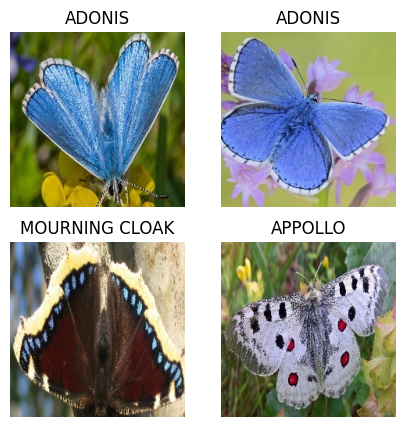

In [ ]:
visualize_dataset(image_datasets, 'train')

**Test Dataset**

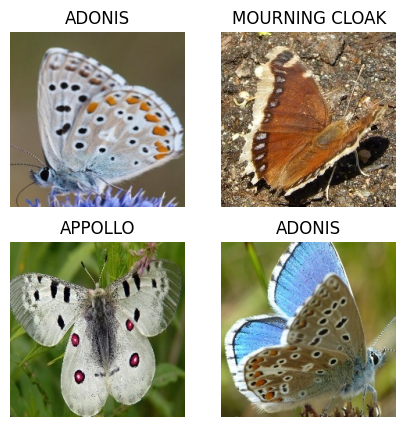

In [ ]:
visualize_dataset(image_datasets, 'test')

### Step 4. Create a Convolutional Neural Network model to learn about your training set

In [ ]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs, device):
  for epoch in range(num_epochs):
      for phase in ['train', 'test']:
          if phase == 'train':
              model.train()
          else:
              model.eval()

          running_loss = 0.0
          running_corrects = 0

          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              optimizer.zero_grad()

              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = running_corrects.double() / dataset_sizes[phase]
          print(f'Epoch: {epoch + 1}')
          print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

  print("Training complete!")

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(start_dim=1),
    nn.Linear(28 * 28 * 64, 3)
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_model(model, criterion, optimizer, dataloaders, num_epochs=10, device=device)

train Loss: 0.9242 Acc: 0.5333
test Loss: 0.5376 Acc: 0.7467
train Loss: 0.3970 Acc: 0.8400
test Loss: 0.3688 Acc: 0.9067
train Loss: 0.2260 Acc: 0.9000
test Loss: 0.3172 Acc: 0.9467
train Loss: 0.1458 Acc: 0.9533
test Loss: 0.3199 Acc: 0.9333
train Loss: 0.1408 Acc: 0.9500
test Loss: 0.1641 Acc: 0.9333
train Loss: 0.0511 Acc: 0.9867
test Loss: 0.3093 Acc: 0.9333
train Loss: 0.1725 Acc: 0.9333
test Loss: 0.1746 Acc: 0.9067
train Loss: 0.0898 Acc: 0.9567
test Loss: 0.2980 Acc: 0.9467
train Loss: 0.0509 Acc: 0.9833
test Loss: 0.2393 Acc: 0.9067
train Loss: 0.0345 Acc: 0.9800
test Loss: 0.2817 Acc: 0.9467
Training complete!


### Step 5. Make predictions on the test data and compare them to the expected categories

In [ ]:
def show_predictions(model, dataset):
  figure = plt.figure(figsize=(6, 6), dpi=100)
  cols, rows = 2, 2
  model.eval()
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()
      img, label = dataset[sample_idx]
      with torch.no_grad():
        outputs = model(img.unsqueeze(0))
      _, predicted = torch.max(outputs.data, 1)

      class_name = dataset.classes[label]
      pred_class_name = dataset.classes[predicted.item()]
      figure.add_subplot(rows, cols, i)
      plt.title(f'Predicted class: {pred_class_name}\nActual class: {class_name}')
      plt.axis("off")
      plt.imshow(img.permute(1, 2, 0).squeeze())
      plt.tight_layout()
  plt.show()

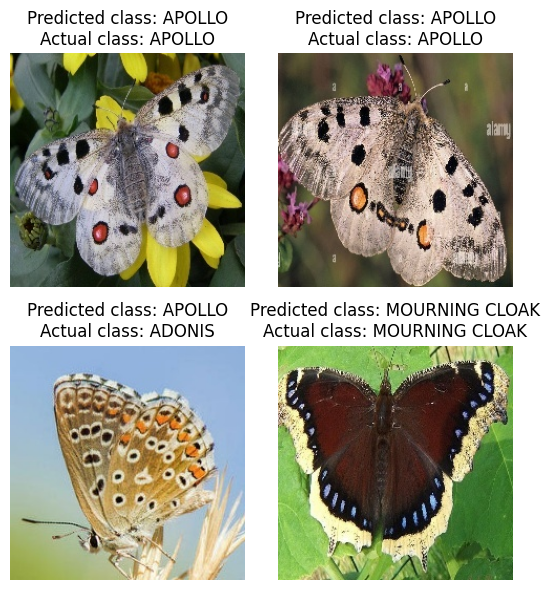

In [ ]:
show_predictions(model, image_datasets['test'])

### Step 6: Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.

In [ ]:
# Create a new model with the correct final layer
new_model = models.googlenet(weights='IMAGENET1K_V1')
new_model.fc = nn.Linear(new_model.fc.in_features, 3)  # Adjust to match the desired output units

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 121MB/s]


### Step 7: Train the GoogleNet model and compare the accuracy with the first model.

In [ ]:
# Freeze all layers except the final classification layer
for name, param in new_model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters
train_model(new_model, criterion, optimizer, dataloaders, num_epochs=10, device=device)

train Loss: 0.8092 Acc: 0.6567
test Loss: 0.4054 Acc: 0.9333
train Loss: 0.5007 Acc: 0.8133
test Loss: 0.2209 Acc: 0.9867
train Loss: 0.4344 Acc: 0.8467
test Loss: 0.1892 Acc: 0.9467
test Loss: 0.1316 Acc: 0.9867
train Loss: 0.3159 Acc: 0.8967
test Loss: 0.1113 Acc: 0.9867
train Loss: 0.4405 Acc: 0.8267
test Loss: 0.0921 Acc: 1.0000
train Loss: 0.3087 Acc: 0.8833
test Loss: 0.0868 Acc: 0.9733
train Loss: 0.3350 Acc: 0.8800
test Loss: 0.0900 Acc: 0.9867
train Loss: 0.3284 Acc: 0.8833
test Loss: 0.0811 Acc: 0.9867
train Loss: 0.3019 Acc: 0.8767
test Loss: 0.0611 Acc: 1.0000
Training complete!


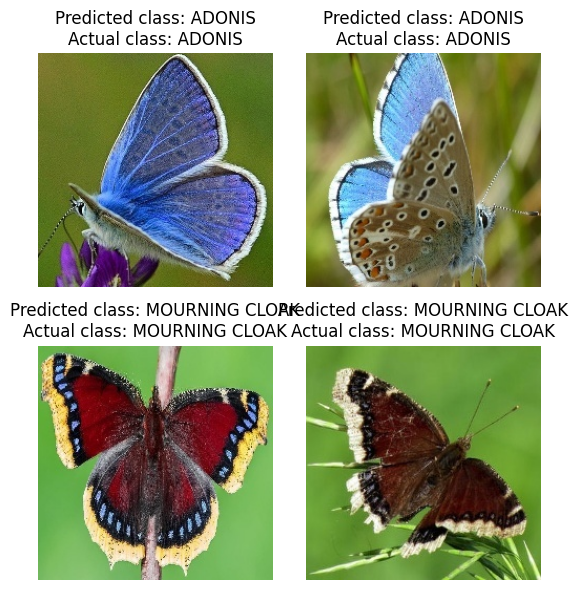

In [ ]:
show_predictions(new_model, image_datasets['test'])

**Comparison with the previous model**

We see that googlenet model achieves a test accuracy of 100 % as compared to the previous model that achieves a test accuracy of 94.67 %. This is because we use pretrained ImageNet weights in the googlenet model, which results in strong features for classification of butterflies.